In [20]:
import sys
import os
import matplotlib.pyplot as plt
% matplotlib inline
import pickle
# Import class
parent_dir = os.path.dirname(os.getcwd())
class_dir = os.path.join(parent_dir, 'Scripts')
sys.path.insert(0, class_dir)
import NBAStats
import numpy as np
import datetime as dt
import random
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

C:\Users\johnn\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
parent_dir = os.path.dirname(os.getcwd())
stats_file = os.path.join(parent_dir, 'Data', 'nba_stats.pickle')
print(stats_file)
nba_stats = pickle.load(open(stats_file, 'rb'))

C:\Users\johnn\Desktop\github\nba_stats\Data\nba_stats.pickle


In [3]:
def get_player_df(nba_stats, player, player_id=False):
    ''' Get the dataframe containing info on referenced player. If player_id=True, player id given instead of name'''
    if player_id:
        if player not in nba_stats.get_player_stats().keys():
            raise ValueError('player_id {} not found'.format(player))
        
        return nba_stats.get_player_stats()[player].sort_index(ascending=False)
    else:
        if player not in nba_stats.get_player_name_id_dict().keys():
            raise ValueError('player name {} not found'.format(player))
        
        return nba_stats.get_player_stats()[nba_stats.get_player_name_id_dict()[player]].sort_index(ascending=False)

# Clean data
Write a few functions to clean the data into a format we like:
* Add distinction between 3pt and 2pt FG
* Converts relevant columns to numeric data

In [4]:
def get_FG2(player_df):
    ''' Adds FG2M, FG2A, and FG2_PCT '''
    player_df['FG2M'] = player_df['FGM'] - player_df['FG3M']
    player_df['FG2A'] = player_df['FGA'] - player_df['FG3A']
    player_df['FG2_PCT'] = player_df['FG2M'].div(player_df['FG2A'].apply(lambda x: 0 if x is None else max(1, x)))
    
    return player_df

In [5]:
def player_df_convert_numeric(player_df):
    ''' Returns a dataframe that converts relevant columns to numeric 
    Columns converted:
    MIN
    '''
    player_df['MIN'] = player_df['MIN'].apply(
        lambda str_min: int(str_min[:-3]) + int(str_min[-2:])/60.0 if str_min is not None else 0 )

    return player_df

In [6]:
def jitter(x, std=0.1):
    ''' Takes in a series and adds some noise. Makes plotting easier'''
    return x + np.random.randn(len(x)) * std

# Analysis
Do preliminary analysis on one single player with lots of data. Picked Stephen Curry arbitrarily.

In [7]:
df_player = get_player_df(nba_stats, 'Stephen Curry')
df_player = player_df_convert_numeric(df_player)
df_player = get_FG2(df_player)

## FGA
Hypothesise that FGA is Poisson. Scatter plot seems to support this. Mean looks linear, and variance increases with MIN.

Text(0,0.5,'Field goal attempts')

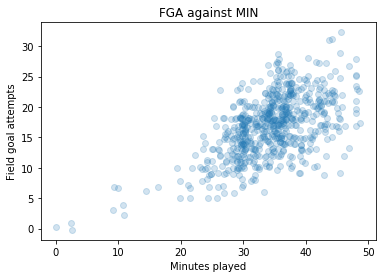

In [8]:
df_player_played = df_player[df_player.MIN > 0]
plt.scatter(x=df_player_played.MIN, y=jitter(df_player_played.FGA, std=0.2), alpha=0.2)
plt.title('FGA against MIN')
plt.xlabel('Minutes played')
plt.ylabel('Field goal attempts')

In [9]:
# sns.lmplot(x='MIN', y= 'FGA', data=df_player_played)

### Linear regression
Run a linear regression to get an estimate for $\lambda$

#### Linear regression with sklearn

In [10]:
import sklearn.linear_model

X = np.array(df_player_played.MIN).reshape(-1, 1)
y = np.array(df_player_played.FGA)

lin_regr_FGA = sklearn.linear_model.LinearRegression(fit_intercept=False) # Set intercept to 0
lin_regr_FGA.fit(X, y)

# Estimated parameters
print('Intercept {}'.format(lin_regr_FGA.intercept_))
print('Slope {}'.format(lin_regr_FGA.coef_))

Intercept 0.0
Slope [ 0.48948064]


Plot regressed line on top of scatter

Text(0.5,1,'FGA = 0.489 * MIN')

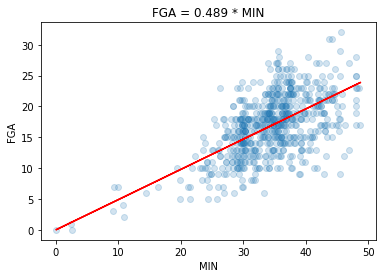

In [11]:
plt.scatter(X, y, alpha=0.2)
plt.plot(X, lin_regr_FGA.predict(X), c='red')
plt.xlabel('MIN')
plt.ylabel('FGA')
plt.title('FGA = {} * MIN'.format(round(lin_regr_FGA.coef_[0], 3)))

Look at the residuals and plot. Seems fairly random. Heteroskedastic as expected.

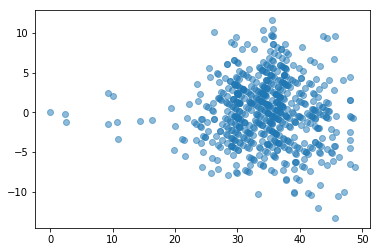

In [12]:
residuals = y - lin_regr_FGA.predict(X)
plt.scatter(X, residuals, alpha=0.5)

Check out what the residuals squared is and fit a regression. The result is promising. It looks like E[FGA] = 0.49 MIN and Var[FGA] = 0.5 MIN. This is what we would expect if FGA is a poisson process as if X ~ Poi($\lambda$t) then E[X] = $\lambda$ t and Var[X] = $\lambda$ t

Text(0.5,1,'Variance = 0.5 MIN')

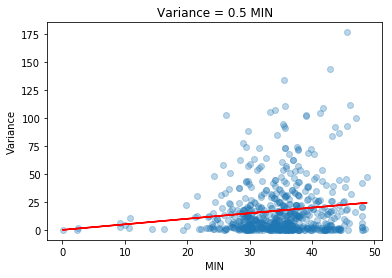

In [13]:
residuals_sq = residuals ** 2

lm_res_sq = sklearn.linear_model.LinearRegression(fit_intercept=False)
lm_res_sq.fit(X, residuals_sq)
plt.scatter(X, residuals_sq, alpha=0.3)
plt.plot(X, lm_res_sq.predict(X), c='red')
plt.xlabel('MIN')
plt.ylabel('Variance')
plt.title('Variance = {} MIN'.format(round(lm_res_sq.coef_[0], 2)))

## Other players
Repeat this analysis for other players to check that they're generally consistent.

In [14]:
def get_lambdas(nba_stats, player_name):
    '''
    Run regression to get lambda for FGA/MIN and res^2/MIN
    Returns a tuple
    '''
    df_player = get_player_df(nba_stats, player_name)
    
    # Clean data
    df_player = player_df_convert_numeric(df_player)
    df_player_played = df_player[df_player.MIN > 0]
    
    if len(df_player_played) == 0:
        return (player_name, 0, 0)
    # Fit model
    X = np.array(df_player_played.MIN).reshape(-1, 1)
    y = np.array(df_player_played.FGA)

    lin_regr_FGA = sklearn.linear_model.LinearRegression(fit_intercept=False) # Set intercept to 0
    lin_regr_FGA.fit(X, y)

    # Estimated parameters
    lambda_FGA_MIN = lin_regr_FGA.coef_[0]
    
    # Run on residuals squared
    residuals = y - lin_regr_FGA.predict(X)
    residuals_sq = (y - lin_regr_FGA.predict(X)) ** 2

    lm_res_sq = sklearn.linear_model.LinearRegression(fit_intercept=False)
    lm_res_sq.fit(X, residuals_sq)
    
    lambda_res_sq = lm_res_sq.coef_[0]
    
    return (player_name, lambda_FGA_MIN, lambda_res_sq, len(df_player_played))

In [15]:
all_player_names = nba_stats.get_player_name_id_dict().keys()
list_lambdas = []
for player in all_player_names:
    list_lambdas.append(get_lambdas(nba_stats, player))

df_lambdas = pd.DataFrame(list_lambdas, columns=['Name', 'FGA_per_MIN', 'lambda_variance', 'n_games'])

Seems to be fairly consistent across players.

Text(0,0.5,'Variance per minute')

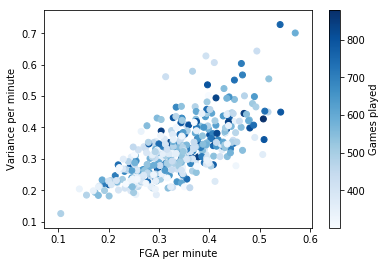

In [16]:
df_sig_games = df_lambdas[df_lambdas.n_games>300]

plt.scatter(x='FGA_per_MIN', y='lambda_variance', data=df_sig_games, alpha=1, c='n_games', cmap='Blues')
plt.colorbar().ax.set_ylabel('Games played')
plt.xlabel('FGA per minute')
plt.ylabel('Variance per minute')

### Regression
Do a weighted linear regression on above plot. Slope is very close to one. Conclude that there is enough evidence to show that FGA are Poisson distributed for all players.

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


Text(0,0.5,'Variance per minute')

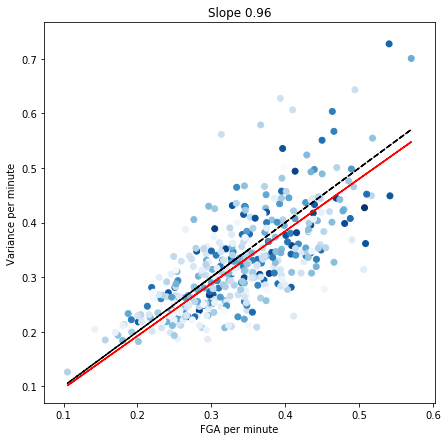

In [17]:
X = df_sig_games.FGA_per_MIN.reshape(-1, 1)
y = df_sig_games.lambda_variance
weights = df_sig_games.n_games

lm_lambda_variance = sklearn.linear_model.LinearRegression(fit_intercept=False)
lm_lambda_variance.fit(X, y, weights)

slope = lm_lambda_variance.coef_[0]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(X, y, c=weights, cmap='Blues')
ax.plot(X, lm_lambda_variance.predict(X), c='red')
ax.plot(X, X, '--', c='black', )
ax.set_title('Slope {}'.format(round(slope, 2)))
ax.set_xlabel('FGA per minute')
ax.set_ylabel('Variance per minute')

# Split between 2, 3 pt FG

In [72]:
def get_FG3A_prop_MIN_params(nba_stats, player):
    ''' Returns the p value of the slope of FG3A_prop against MIN '''

    df_player = get_player_df(nba_stats, player)
    df_player = player_df_convert_numeric(df_player)

    df_player_played = df_player[df_player['MIN'] > 0]

    if len(df_player_played) <= 10:
        return (None, 0, 0, 0) # Too small sample

    df_player_played['FG3A_prop'] = df_player_played['FG3A'].div(df_player_played['FGA'].apply(lambda x: max(x, 1)))

    X = np.array(df_player_played['MIN'], dtype='float').reshape(-1, 1)
    y = np.array(df_player_played['FG3A_prop'], dtype='float')

    X = sm.add_constant(X)

    lm_prop_FG3A_MIN = sm.OLS(y, X).fit()
    slope_p_value = lm_prop_FG3A_MIN.pvalues[1]
    intercept = lm_prop_FG3A_MIN.params[0]
    slope = lm_prop_FG3A_MIN.params[1]

    return (player, intercept, slope, slope_p_value)

In [ ]:
get_FG3A_prop_MIN_params

In [76]:
list_slope_p_value = []
for player in nba_stats.get_player_name_id_dict().keys():
    name, intercept, slope, slope_p_value = get_FG3A_prop_MIN_params(nba_stats, player)

    if name is not None:
        list_slope_p_value.append((name, intercept, slope, slope_p_value))

C:\Users\johnn\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\johnn\Anaconda3\lib\site-packages\statsmodels\base\model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\johnn\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2

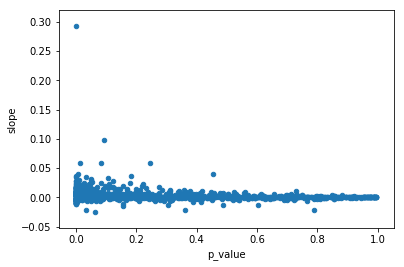

In [79]:
df_slope_p_values = pd.DataFrame(list_slope_p_value, columns=['Name', 'intercept', 'slope', 'p_value'])
df_slope_p_values.plot.scatter(x='p_value', y='slope')
# (df_slope_p_values['p_value'] < 0.05).sum()/float(len(df_slope_p_values))

On initial inspection, it doesn't seem like FG3A_prop is correlated with MIN. Running analysis on all players with 100 games or more, 35% of them have a statistically significant slope (p < 0.05). This may be a coincidence, or some players may actually have a correlation between proportion of 3s taken and minutes played. This doesn't mean causation, however, as there may be a hidden factor. E.g. playing hard team -> good player plays more minutes -> harder to drive because good defensive opponent so shoot more 3s.

For those with a significant p value, the effect seems to be positive. So more minutes correlates somewhat with higher proportion of threes. 

# FT analysis
Repeat same Poisson analysis but with free throws

In [ ]:
import statsmodels.api as sm

In [ ]:
X = np.array(df_player_played['MIN'], dtype='float').reshape(-1, 1)
y = np.array(df_player_played['FTA'], dtype='float')

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

In [ ]:
X = df_player_played['MIN'].reshape(-1, 1)
y = df_player_played['FTA']

lm_FT_MIN = sklearn.linear_model.LinearRegression(fit_intercept=True)
lm_FT_MIN.fit(X, y)
print('intercept {} \nslope {}'.format(lm_FT_MIN.intercept_, lm_FT_MIN.coef_))

plt.figure()
plt.scatter(X, y, alpha=0.2)
plt.plot(X, lm_FT_MIN.predict(X), c='red')